## Exercise - DL Tutorial 06

### student names:

Submit you solution by 16 June 23:59 to manuel.milling@informatik.uni-augsburg.de OR maurice.gerczuk@informatik.uni-augsburg.de

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from os.path import basename
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, BatchNormalization, Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

2022-06-16 22:32:33.713557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-16 22:32:33.713594: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
#train_speakers = ["03", "08", "09", "10", "11", "12", "13"]
train_speakers = ["03", "08", "09", "10", "11"]
validation_speakers = ["12", "13"]
test_speakers = ["14", "15", "16"]
data_path = "./emodb/wav/"
label_dict = {"A" : 0, "F": 1, "L": 2, "N": 3, "T": 4, "W": 5, "E": 6}
num_classes = len(label_dict.keys())
cutoff_length = 4 #s

2. Prepare data and labels by cutting/zero-padding to 4 seconds, extracting spectrograms. 

In [11]:
files = glob(data_path + "*.wav")
files.sort()
x_train = []
y_train = []
x_test = []
y_test = []
x_validation = []
y_validation = []
print(len(files))
for file in files:
    filename = basename(file)
    speaker_id = filename[0:2]
    label_num = label_dict[filename[5]]
    signal, sr = librosa.load(file)
    signal_len = signal.shape[0]
    if signal_len < cutoff_length * sr:                
        signal = np.concatenate((signal, np.zeros(cutoff_length * sr - signal_len)))    
    signal = signal[0:cutoff_length * sr]
    melspectrogram = librosa.feature.melspectrogram(y = signal)
    log_melspectrogram = librosa.power_to_db(melspectrogram)

    log_melspectrogram = np.expand_dims(log_melspectrogram, 2)
    
    if speaker_id in train_speakers:
        x_train.append(log_melspectrogram)
        y_train.append(label_num)
    elif speaker_id in validation_speakers:
        x_validation.append(log_melspectrogram)
        y_validation.append(label_num)
    else:
        x_test.append(log_melspectrogram)
        y_test.append(label_num)

x_train = np.stack(x_train)
x_validation = np.stack(x_validation)
x_test = np.stack(x_test)
y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_validation = tf.keras.utils.to_categorical(y_validation, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

535


In [15]:
print("x_train shape:\t\t{}".format(x_train.shape))
print("x_validation shape:\t{}".format(x_validation.shape))
print("x_test shape:\t\t{}".format(x_test.shape))
print("y_train shape:\t\t{}".format(y_train.shape))
print("y_validation shape:\t{}".format(y_validation.shape))
print("y_test shape:\t\t{}".format(y_test.shape))

x_train shape:		(243, 128, 173, 1)
x_validation shape:	(96, 128, 173, 1)
x_test shape:		(196, 128, 173, 1)
y_train shape:		(243, 7)
y_validation shape:	(96, 7)
y_test shape:		(196, 7)


3. Implement CNN-based model

4. Train model with early stopping. Evaluate on test data and plot the training history.

In [29]:
model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 173, 8)       80        
                                                                 
 batch_normalization_3 (Batc  (None, 128, 173, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 128, 173, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 86, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 84, 16)        1168      
                                                                 
 activation_10 (Activation)  (None, 62, 84, 16)       

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, epochs=30, batch_size=16, callbacks=[callback], 
                    validation_data=[x_validation, y_validation])
model.evaluate(x_test, y_test)

Epoch 1/30
16/16 [==============================] - 4s 213ms/step - loss: 2.6817 - accuracy: 0.2881 - val_loss: 7.3451 - val_accuracy: 0.2500
Epoch 2/30
16/16 [==============================] - 2s 140ms/step - loss: 1.6353 - accuracy: 0.4280 - val_loss: 2.8469 - val_accuracy: 0.3125
Epoch 3/30
16/16 [==============================] - 2s 149ms/step - loss: 1.0651 - accuracy: 0.7037 - val_loss: 2.0452 - val_accuracy: 0.3854
Epoch 4/30
16/16 [==============================] - 2s 147ms/step - loss: 0.6383 - accuracy: 0.8066 - val_loss: 2.1732 - val_accuracy: 0.3958
Epoch 5/30
16/16 [==============================] - 2s 151ms/step - loss: 0.2955 - accuracy: 0.9465 - val_loss: 1.6965 - val_accuracy: 0.4479
Epoch 6/30
16/16 [==============================] - 3s 162ms/step - loss: 0.1888 - accuracy: 0.9794 - val_loss: 2.0221 - val_accuracy: 0.4375
Epoch 7/30
16/16 [==============================] - 3s 161ms/step - loss: 0.1156 - accuracy: 0.9877 - val_loss: 1.4327 - val_accuracy: 0.5312
Epoch 

[1.634341835975647, 0.5102040767669678]

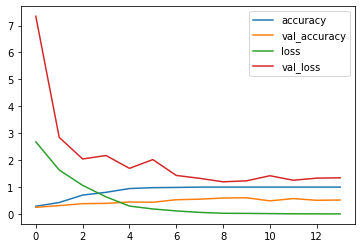

In [31]:
plt.plot(history.history['accuracy'], label='accuracy'), 
plt.plot(history.history['val_accuracy'], label='val_accuracy') 
plt.plot(history.history['loss'], label='loss'),
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()